# Softmax exercise

We will implement a softmax classifier that is trained on the CIFAR10 dataset. The output is a model that is able to classify the input image into the 10 different classes of the CIFAR10 dataset.

Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission.

You will:

- implement a fully-vectorized **loss function** for the Softmax classifier
- implement the fully-vectorized expression for its **analytic gradient**
- use a validation set to **tune the learning rate** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt
import time
import pickle
from random import shuffle

from six.moves import cPickle as pickle
import numpy as np
import os
from imageio import imread
import platform
from torchvision import datasets


%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [179]:
from google.colab import drive
drive.mount('/content/drive')

MessageError: Error: credential propagation was unsuccessful

Load the dataset

In [166]:
def load_pickle(f):
    version = platform.python_version_tuple()
    if version[0] == '2':
        return  pickle.load(f)
    elif version[0] == '3':
        return  pickle.load(f, encoding='latin1')
    raise ValueError("invalid python version: {}".format(version))

def load_CIFAR_batch(filename):
  """ load single batch of cifar """
  with open(filename, 'rb') as f:
    datadict = load_pickle(f)
    X = datadict['data']
    Y = datadict['labels']
    X = X.reshape(10000, 3, 32, 32).transpose(0,2,3,1).astype("float")
    Y = np.array(Y)
    return X, Y

def load_CIFAR10(ROOT):
  """ load all of cifar """
  xs = []
  ys = []
  datasets.CIFAR10(
        root="data/", train=True,
        download=True, transform=None,
    )
  for b in range(1,6):
    f = os.path.join(ROOT, 'data_batch_%d' % (b, ))
    X, Y = load_CIFAR_batch(f)
    xs.append(X)
    ys.append(Y)
  Xtr = np.concatenate(xs)
  Ytr = np.concatenate(ys)
  del X, Y
  return Xtr, Ytr


def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the linear classifier.
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = 'data/cifar-10-batches-py'
    X_train, y_train = load_CIFAR10(cifar10_dir)

    # subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]

    # Normalize the data: subtract the mean image and divide by variance
    mean = np.array([0.4914, 0.4822, 0.4465])
    std = np.array([0.2023, 0.1994, 0.2010])
    X_train = np.divide(np.subtract( X_train/255 , mean[np.newaxis,np.newaxis,:]), std[np.newaxis,np.newaxis,:])
    X_val = np.divide(np.subtract( X_val/255 , mean[np.newaxis,np.newaxis,:]), std[np.newaxis,np.newaxis,:])

    # Preprocessing: reshape the image data into rows
    X_train = np.reshape(X_train, (X_train.shape[0], -1))
    X_val = np.reshape(X_val, (X_val.shape[0], -1))

    # add bias dimension and transform into columns
    X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
    X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])

    return X_train, y_train, X_val, y_val


# Invoke the above function to get our data.
X_train, y_train, X_val, y_val = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)

Train data shape:  (49000, 3073)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3073)
Validation labels shape:  (1000,)


## Softmax Classifier

Here, you implement **softmax_loss_vectorized**. This function just returns the loss and gradient after applying the softmax function.


In [112]:
def softmax_loss_vectorized(W, X, y):
    """
    Softmax loss function, vectorized version.

    Inputs have dimension D, there are C classes, and we operate on minibatches
    of N examples.

    Inputs:
    - W: A numpy array of shape (D, C) containing weights.
    - X: A numpy array of shape (N, D) containing a minibatch of data.
    - y: A numpy array of shape (N,) containing training labels; y[i] = c means
    that X[i] has label c, where 0 <= c < C.

    Returns a tuple of:
    - loss as single float
    - gradient with respect to weights W; an array of same shape as W
    """

    n=len(y)
    d,c=W.shape

    # Initialize the loss and gradient to zero.
    loss = 0.0
    dW = np.zeros_like(W)

    # Compute the loss
    res=X@W
    S=np.exp(res)
    Snorm=(S.T/(S.sum(axis=1))).T # the predicted probability for each class


    y_2=y.T.reshape(n,1).repeat(c,axis=1)
    grid=np.indices(y_2.shape)[1]
    T=(y_2==grid)     # create grid to select the true label probability

    loss=(1/n)*np.sum(-np.log((Snorm)[T]))    # average loss of the samples
    dW=(1/n)*(X.T)@(Snorm-T.astype(int))      # dL/dW


    return loss, dW

In [78]:
X=np.array([[1,4],[2,4],[1,1],[1,10],[7,4]])
W=np.array([[4,6,1],[2,3,6]]).astype(float)
y=np.array([0,0,1,2,0])


softmax_loss_vectorized(W,X,y)

(8.259545551598615,
 array([[-1.99158152,  1.4166204 ,  0.57496112],
        [-2.39156418,  0.8648463 ,  1.52671788]]))

[[3. 6. 1.]
 [2. 3. 6.]]
10.2541554697375
-1.996822421121171
8.199198341763763
2.515151515151515
-1.9913331769649443


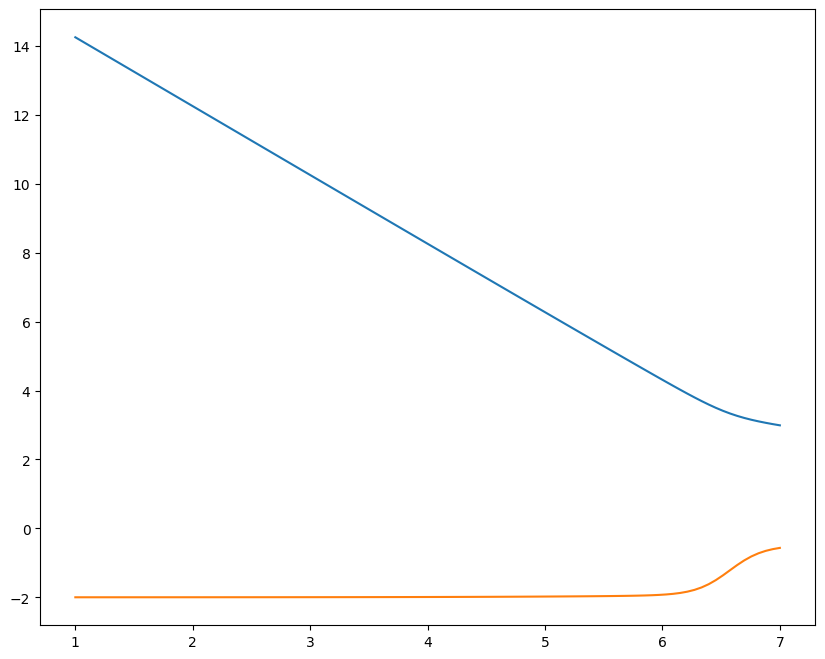

In [54]:
X=np.array([[1,4],[2,4],[1,1],[1,10],[7,4]])
y=np.array([0,0,1,2,0])
losses=[]
grads=[]
for i in np.linspace(1,7,100):
  W=np.array([[i,6,1],[2,3,6]]).astype(float)
  a,b=softmax_loss_vectorized(W,X,y)
  losses.append(a)
  grads.append(b[0,0])
  if i==3:
    print(W)
    print(losses[-1])
    print(grads[-1])

print(losses[50])
print(np.linspace(1,4,100)[50])
print(grads[50])

plt.plot(np.linspace(1,7,100),losses)
plt.plot(np.linspace(1,7,100),grads)
plt.show()

In [21]:
X=np.array([[1,4],[2,4],[1,1],[1,10],[7,4]])
W=np.array([[4,6,1],[2,3,6]]).astype(float)
y=np.array([0,0,1,2,0])

y_2=y.T.reshape(5,1).repeat(3,axis=1)
grid=np.indices(y_2.shape)[1]

S=X@W
res=np.exp(S)
res=(res.T/(res.sum(axis=1))).T

T=(y_2==grid)

loss=-np.log((res)[y_2==grid])

grad=(X.T)@(res-T.astype(int))

print('X')
print(X)
print('\nW')
print(W)
print('\ny')
print(y)
print('\nT')
print(T.astype(int))
print('\nSnorm')
print(res)
print('\nloss')
print(loss.sum())
print('\ngrad')
print(grad/len(y))


X
[[ 1  4]
 [ 2  4]
 [ 1  1]
 [ 1 10]
 [ 7  4]]

W
[[4. 6. 1.]
 [2. 3. 6.]]

y
[0 0 1 2 0]

T
[[1 0 0]
 [1 0 0]
 [0 1 0]
 [0 0 1]
 [1 0 0]]

Snorm
[[2.25826503e-06 9.11049137e-04 9.99086693e-01]
 [3.99865265e-05 1.19198156e-01 8.80761858e-01]
 [4.20100661e-02 8.43794734e-01 1.14195199e-01]
 [8.53304763e-17 1.38879439e-11 1.00000000e+00]
 [1.52299795e-08 9.99999985e-01 1.02618795e-10]]

loss
41.29772775799307

grad
[[-1.99158152  1.4166204   0.57496112]
 [-2.39156418  0.8648463   1.52671788]]


In [59]:
W[0,0]=W[0,0]+1
S=X@W
res=np.exp(S)
res=(res.T/(res.sum(axis=1))).T
loss1=(-np.log((res)[y_2==grid])).sum()
loss1=loss1/len(y)
print(W)
print(softmax_loss_vectorized(W,X,y)[0])

W[0,0]=W[0,0]-2
S=X@W
res=np.exp(S)
res=(res.T/(res.sum(axis=1))).T
loss2=(-np.log((res)[y_2==grid])).sum()
loss2=loss2/len(y)
print(W)
print(softmax_loss_vectorized(W,X,y)[0])

gradient0=(loss1-loss2)/(2)
print(loss1,loss2)
print(gradient0)
print(len(y))

[[5. 6. 1.]
 [2. 3. 6.]]
6.273540502970141
[[3. 6. 1.]
 [2. 3. 6.]]
10.2541554697375
6.273540502970141 10.2541554697375
-1.9903074833836794
5


In [ ]:
a,b=0,0
print(S)
print(T)

S1=res.copy()
S1[a,b]=S1[a,b]+0.0000001
res=np.exp(S1)
res=(res.T/(res.sum(axis=1))).T
loss1=(-np.log((res)[y_2==grid])).sum()


S2=res.copy()
S2[a,b]=S2[a,b]-0.0000001
res=np.exp(S2)
res=(res.T/(res.sum(axis=1))).T
loss2=(-np.log((res)[y_2==grid])).sum()

gradient0=(loss1-loss2)/(0.0000002)
print(gradient0)
grad=res-T.astype(int)
print(grad)

[[12. 18. 25.]
 [16. 24. 26.]
 [ 6.  9.  7.]
 [24. 36. 61.]
 [36. 54. 31.]]
[[ True False False]
 [ True False False]
 [False  True False]
 [False False  True]
 [ True False False]]
554.1112663465242
[[-0.66668636  0.33334205  0.3333443 ]
 [-0.66666733  0.3333328   0.33333453]
 [ 0.33333274 -0.66666556  0.33333282]
 [ 0.33333259  0.33333259 -0.66666518]
 [-0.66666741  0.33333482  0.33333259]]


In [7]:
x=np.array([1,6,3]).T
print(x)
W=np.array([[4,6,1],[2,3,6]]).astype(float)
print(W)
print(W@x)

[1 6 3]
[[4. 6. 1.]
 [2. 3. 6.]]
[43. 38.]


## This is the Softmax Linear Classifier.
### Implement SGD in the train function.
### Write the predict function to evaluate the performance on both the training and validation set
### Do not touch the loss function. You already defined it above.

In [187]:
class LinearClassifier(object):

    def __init__(self):
        self.W = None

    def train(self, X, y, learning_rate=1e-3, num_iters=100,
            batch_size=200, verbose=False,plot_prog=False):
        """
        Train this linear classifier using stochastic gradient descent.

        Inputs:
        - X: A numpy array of shape (N, D) containing training data; there are N
            training samples each of dimension D.
        - y: A numpy array of shape (N,) containing training labels; y[i] = c
            means that X[i] has label 0 <= c < C for C classes.
        - learning_rate: (float) learning rate for optimization.
        - num_iters: (integer) number of steps to take when optimizing
        - batch_size: (integer) number of training examples to use at each step.
        - verbose: (boolean) If true, print progress during optimization.

        Outputs:
        A list containing the value of the loss function at each training iteration.
        """
        num_train, dim = X.shape
        num_classes = np.max(y) + 1 # assume y takes values 0...K-1 where K is number of classes
        if self.W is None:
            # lazily initialize W
            self.W = 0.001 * np.random.randn(dim, num_classes)

        # Run stochastic gradient descent to optimize W
        loss_history = []
        acc_history=[]
        W_history=[]
        for it in range(num_iters):
            #########################################################################
            # TODO:                                                                 #
            # Sample batch_size elements from the training data and their           #
            # corresponding labels to use in this round of gradient descent.        #
            # Store the data in X_batch and their corresponding labels in           #
            # y_batch; after sampling X_batch should have shape (dim, batch_size)   #
            # and y_batch should have shape (batch_size,)                           #
            #                                                                       #
            # Hint: Use np.random.choice to generate indices. Sampling with         #
            # replacement is faster than sampling without replacement.              #
            #########################################################################

            samples_idx=np.random.choice(num_train,(batch_size))

            X_batch = X[samples_idx]
            y_batch = y[samples_idx]
            #########################################################################
            #                       END OF YOUR CODE                                #
            #########################################################################

            # evaluate loss and gradient and accuracy
            loss, grad = self.loss(X_batch, y_batch)
            loss_history.append(loss)


            y_pred=np.argmax(X.dot(self.W),axis=1)
            acc=((y_pred==y).astype(int)).mean()
            acc_history.append(acc)

            # perform parameter update
            self.W += -learning_rate*grad

            #########################################################################
            # TODO:                                                                 #
            # Update the weights using the gradient and the learning rate.          #
            #########################################################################
            pass
            #########################################################################
            #                       END OF YOUR CODE                                #
            #########################################################################

            if verbose and it % 100 == 0:
                print('iteration %d / %d: loss %f' % (it, num_iters, loss))

        if plot_prog==True:
          plt.plot(range(num_iters),loss_history)
          plt.show()

        return loss_history

    def predict(self, X):
        """
        Use the trained weights of this linear classifier to predict labels for
        data points.

        Inputs:
        - X: A numpy array of shape (N, D) containing training data; there are N
        training samples each of dimension D.

        Returns:
        - y_pred: Predicted labels for the data in X. y_pred is a 1-dimensional
        array of length N, and each element is an integer giving the predicted
        class.
        """
        y_pred = np.zeros(X.shape[0])

        S=X.dot(self.W)
        y_pred=np.argmax(S,axis=1)

        ###########################################################################
        # TODO:                                                                   #
        # Implement this method. Store the predicted labels in y_pred.            #
        ###########################################################################

        ###########################################################################
        #                           END OF YOUR CODE                              #
        ###########################################################################
        return y_pred

    def loss(self, X_batch, y_batch):
        """
        Compute the loss function and its derivative.
        Subclasses will override this.

        Inputs:
        - X_batch: A numpy array of shape (N, D) containing a minibatch of N
            data points; each point has dimension D.
        - y_batch: A numpy array of shape (N,) containing labels for the minibatch.

        Returns: A tuple containing:
        - loss as a single float
        - gradient with respect to self.W; an array of the same shape as W
        """
        pass


Finally, the softmax class is inherited from LinearClassifier and uses the softmax_loss_vectorized function as its loss:

In [143]:
WW=[[1,4],[2,3],[1,1]]
np.amax(WW,axis=1,keepdims=True)
np.argmax(WW,axis=1)

array([1, 1, 0])

In [185]:
class Softmax(LinearClassifier):
    """ A subclass that uses the Softmax + Cross-entropy loss function """

    def loss(self, X_batch, y_batch):
        return softmax_loss_vectorized(self.W, X_batch, y_batch)

In [165]:
W = np.random.randn(3073, 10) * 0.0001
tic = time.time()
loss_vectorized, grad_vectorized = softmax_loss_vectorized(W, X_val, y_val)
toc = time.time()
print('vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

vectorized loss: 2.302455e+00 computed in 0.022331s


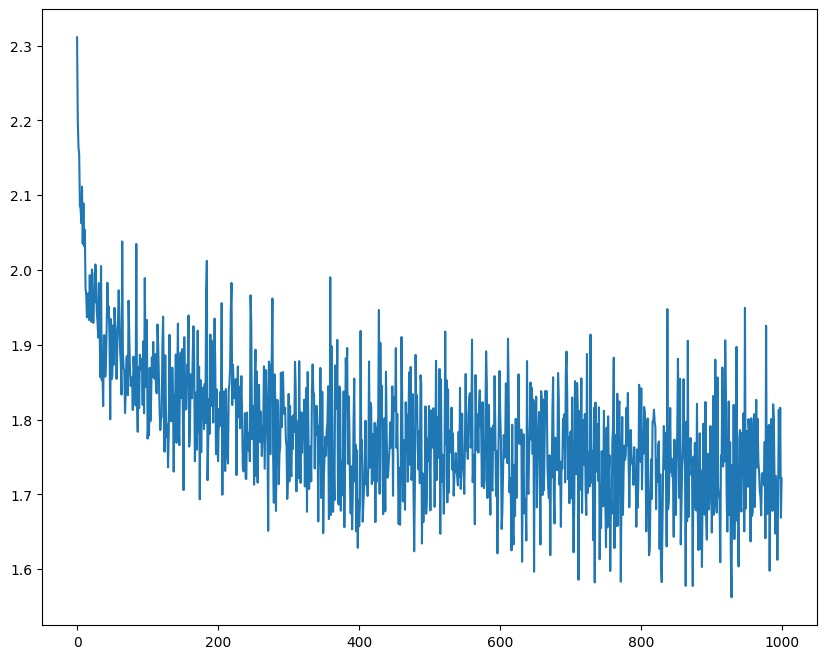

[2.311195027281051,
 2.2007905505551855,
 2.1642747955283324,
 2.1547955322315784,
 2.0856758568056963,
 2.0819672887124905,
 2.062634390339182,
 2.1115540971842717,
 2.0349142637665625,
 2.089194078073522,
 2.031768058260228,
 2.053813280589544,
 1.9756529012261625,
 1.9665593075878298,
 1.9367403868635578,
 1.9685562866248012,
 1.9687187955029297,
 1.933151682559022,
 1.9930099522661464,
 1.9467295855638185,
 1.9309049806966903,
 2.000751363492447,
 1.993952565165407,
 1.9293341008600686,
 1.965776476753511,
 1.9567293080590282,
 2.0074693286946377,
 1.9826641706447512,
 1.943543198397017,
 1.9303293716594043,
 1.909801728122568,
 1.9825847149243236,
 1.915452101752469,
 1.8567658654121784,
 2.0053675501231956,
 1.8527077742137272,
 1.8627746182543874,
 1.81814082266301,
 1.9125551676296453,
 1.9128573896284908,
 1.8574222021518711,
 1.8802159853657787,
 1.9248277215629805,
 1.9830910270725997,
 1.9374520226670524,
 1.9513004859685603,
 1.907447231577516,
 1.8004080922491945,
 1.9344

In [186]:
sm=Softmax()
learn_r=3.156362e-03
sm.train(X_train,y_train,learn_r,1000,plot_prog=True)

In [181]:
# Use the validation set to tune hyperparameters (learning rate).
# You should experiment with different ranges for the learning
# rates; if you are careful you should be able to
# get a classification accuracy of over 0.35 on the validation set.
results = {}
best_val = -1
best_softmax = None
learning_rates = [1e-7, 5e-2]

for lr in np.geomspace(learning_rates[0],learning_rates[1],20):
  model=Softmax()
  model.train(X_train,y_train,lr,1000)
  acc_train=((model.predict(X_train)==y_train).astype(int)).mean()
  y_pred=model.predict(X_val)
  acc_val=((y_pred==y_val).astype(int)).mean()
  results[lr]=[acc_train,acc_val]
  if acc_val>best_val:
    best_val=acc_val
    best_softmax=model

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning.                                  #
# Save the best trained softmax classifer in best_softmax.                     #
################################################################################
pass
################################################################################
#                              END OF YOUR CODE                                #
################################################################################

# Print out results.
for lr in sorted(results):
    train_accuracy, val_accuracy = results[lr]
    print('lr %e train accuracy: %f val accuracy: %f' % (
                lr, train_accuracy, val_accuracy))

print('best validation accuracy achieved during cross-validation: %f' % best_val)

lr 1.000000e-07 train accuracy: 0.106612 val accuracy: 0.101000
lr 1.995013e-07 train accuracy: 0.075449 val accuracy: 0.078000
lr 3.980078e-07 train accuracy: 0.124837 val accuracy: 0.125000
lr 7.940308e-07 train accuracy: 0.169224 val accuracy: 0.158000
lr 1.584102e-06 train accuracy: 0.219592 val accuracy: 0.230000
lr 3.160305e-06 train accuracy: 0.224694 val accuracy: 0.235000
lr 6.304850e-06 train accuracy: 0.261102 val accuracy: 0.270000
lr 1.257826e-05 train accuracy: 0.264102 val accuracy: 0.276000
lr 2.509379e-05 train accuracy: 0.289510 val accuracy: 0.306000
lr 5.006245e-05 train accuracy: 0.318551 val accuracy: 0.325000
lr 9.987525e-05 train accuracy: 0.344959 val accuracy: 0.356000
lr 1.992525e-04 train accuracy: 0.367122 val accuracy: 0.372000
lr 3.975113e-04 train accuracy: 0.383327 val accuracy: 0.387000
lr 7.930403e-04 train accuracy: 0.395347 val accuracy: 0.391000
lr 1.582126e-03 train accuracy: 0.406469 val accuracy: 0.402000
lr 3.156362e-03 train accuracy: 0.414837

In [182]:
# evaluate on val set
# Evaluate the best softmax on val set
y_val_pred = best_softmax.predict(X_val)
val_accuracy = np.mean(y_val == y_val_pred)
print('softmax on raw pixels final test set accuracy: %f' % (val_accuracy, ))

softmax on raw pixels final test set accuracy: 0.410000


Save the best_softmax weights using pickle:

In [178]:
with open('drive/MyDrive/Colab Notebooks/softmax_weights.pkl', 'wb') as f:
    pickle.dump(best_softmax.W, f)

FileNotFoundError: [Errno 2] No such file or directory: 'drive/MyDrive/Colab Notebooks/softmax_weights.pkl'

Load the best_softmax weights using pickle:

In [ ]:
with open('drive/MyDrive/Colab Notebooks/softmax_weights.pkl', 'rb') as f:
    W = pickle.load(f)
new_softmax = Softmax()
new_softmax.W = W.copy()

Below is the code to visualize the weights learned for different classes. Try to notice the interesting patterns.

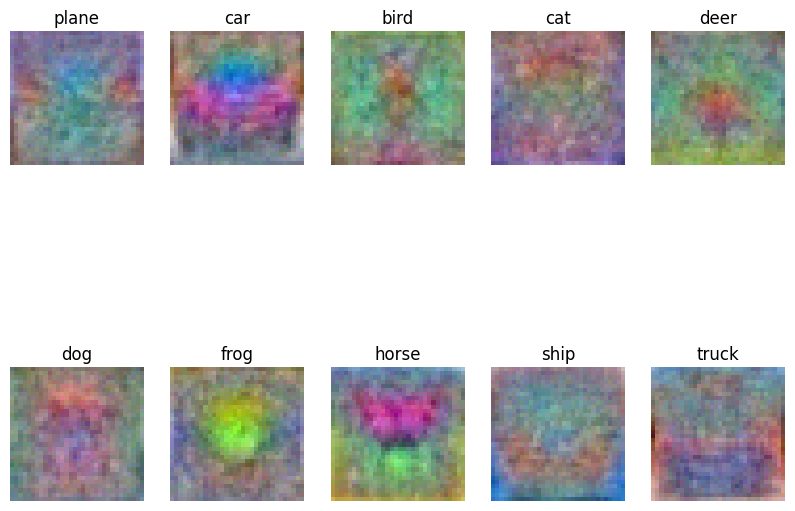

In [183]:
# Visualize the learned weights for each class
w = best_softmax.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)

w_min, w_max = np.min(w), np.max(w)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)

    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])